In [63]:
import pandas as pd
import numpy as np
from datetime import *
from plotnine import *
import statsmodels.api as sm

In [16]:
df = pd.concat([pd.read_csv("data/lichess_swiss_rating_histories_1.csv",parse_dates=['date']),
                pd.read_csv("data/lichess_swiss_rating_histories_2.csv",parse_dates=['date'])])
print(df.shape)
df.head()

(8623368, 4)


,user_id,time_control,date,rating
0,0,Blitz,2019-01-04,2244
1,0,Blitz,2019-01-05,2256
2,0,Blitz,2019-01-06,2231
3,0,Blitz,2019-01-08,2307
4,0,Blitz,2019-01-29,2288


In [5]:
df['user_id'].nunique()

17171

In [6]:
df['date'].max()

'2021-08-03'

In [11]:
# The latest date we have data on
max_outcome_date = df['date'].max()
# The latest date that can be used for training to ensure we'll always have 2 years in advance of outcomes data
max_training_date = max_outcome_date - timedelta(days=365*2)
max_outcome_date,max_training_date

(Timestamp('2021-08-03 00:00:00'), Timestamp('2019-08-04 00:00:00'))

In [13]:
# The earliest date we have data on
minn_training_date = df['date'].min()
minn_training_date

Timestamp('2019-01-01 00:00:00')

In [53]:
# The latest ratings that can be used for training
df_training = df.query('date<=@max_training_date')
df_outcomes = df.query('date>@max_training_date')
latest_training_ratings = df_training.sort_values("date",ascending=False).drop_duplicates(['user_id','time_control'])
latest_training_ratings.sample(5)

,user_id,time_control,date,rating
637431,11342,Bullet,2019-08-02,2113
2948792,15641,Bullet,2019-08-04,1273
1142598,2667,Rapid,2019-08-03,1518
1083190,2533,Classical,2019-07-23,1282
2248754,14434,Blitz,2019-08-04,1840


# Feature Engineering

In [29]:
# Ratings from X days before the max training date
max_training_date_minus_30 = max_training_date-timedelta(days=30)
max_training_date_minus_90 = max_training_date-timedelta(days=90)
max_training_date_minus_180 = max_training_date-timedelta(days=180)
hist_ratings_30 = df.query('date<=@max_training_date_minus_30').sort_values("date",ascending=False).drop_duplicates(['user_id','time_control'])
hist_ratings_90 = df.query('date<=@max_training_date_minus_90').sort_values("date",ascending=False).drop_duplicates(['user_id','time_control'])
hist_ratings_180 = df.query('date<=@max_training_date_minus_180').sort_values("date",ascending=False).drop_duplicates(['user_id','time_control'])
hist_ratings_180.head()

,user_id,time_control,date,rating
7033,10091,Blitz,2019-02-05,1106
1488095,13023,Rapid,2019-02-05,1339
1475936,12996,Bullet,2019-02-05,1722
1476181,12996,Rapid,2019-02-05,1812
1476463,12997,Bullet,2019-02-05,1454


In [30]:
# Peak ratings
hist_ratings_peak = df_training.sort_values("rating",ascending=False).drop_duplicates(['user_id','time_control'])
hist_ratings_peak.head()

,user_id,time_control,date,rating
3141002,6935,Bullet,2019-03-26,2872
4478689,9624,Bullet,2019-07-21,2852
2810666,6252,Bullet,2019-06-26,2847
4478286,9624,Blitz,2019-08-04,2833
3039334,6727,Bullet,2019-05-05,2832


In [194]:
# Add features to base table
df_base = latest_training_ratings.merge(hist_ratings_30[['user_id','time_control','rating']],
                how='left',on=['user_id','time_control'],suffixes=['_latest','_30']).merge(
            hist_ratings_90[['user_id','time_control','rating']],
                how='left',on=['user_id','time_control']).merge(
            hist_ratings_180[['user_id','time_control','rating']],
                how='left',on=['user_id','time_control'],suffixes=['_90','_180']).merge(
            hist_ratings_peak[['user_id','time_control','rating']].rename(columns={'rating':'rating_peak'}),
                how='left',on=['user_id','time_control'])
df_base['rating_30_diff'] = df_base['rating_latest']-df_base['rating_30']
df_base['rating_90_diff'] = df_base['rating_latest']-df_base['rating_90']
df_base['rating_180_diff'] = df_base['rating_latest']-df_base['rating_180']
df_base['rating_peak_diff'] = df_base['rating_latest']-df_base['rating_peak']
df_base['time_control_copy'] = df_base['time_control']
df_base['rating_latest_rounded'] = df_base['rating_latest'].round(-2)
df_base = pd.get_dummies(df_base,columns=['time_control_copy'],prefix_sep="")
df_base.columns = [x.replace("time_control_copy","").lower() for x in df_base.columns]
print(df_base.shape)
df_base.sample(10)

(41530, 17)


,user_id,time_control,date,rating_latest,rating_30,rating_90,rating_180,rating_peak,rating_30_diff,rating_90_diff,rating_180_diff,rating_peak_diff,rating_latest_rounded,blitz,bullet,classical,rapid
32933,2002,Bullet,2019-05-04,961,961.0,961.0,NaN,961,0.0,0.0,NaN,0,1000,0,1,0,0
3778,12981,Blitz,2019-08-04,1875,1903.0,1843.0,1787.0,2005,-28.0,32.0,88.0,-130,1900,1,0,0,0
26028,1236,Classical,2019-06-25,1510,1510.0,NaN,NaN,1510,0.0,NaN,NaN,0,1500,0,0,1,0
32616,3663,Bullet,2019-05-07,1419,1419.0,1407.0,1441.0,1479,0.0,12.0,-22.0,-60,1400,0,1,0,0
34511,7168,Rapid,2019-04-18,1253,1253.0,1253.0,NaN,1324,0.0,0.0,NaN,-71,1300,0,0,0,1
14423,975,Blitz,2019-07-30,1164,1221.0,1300.0,1308.0,1346,-57.0,-136.0,-144.0,-182,1200,1,0,0,0
20480,2921,Blitz,2019-07-17,1517,1526.0,1547.0,NaN,1584,-9.0,-30.0,NaN,-67,1500,1,0,0,0
1713,10448,Bullet,2019-08-04,2036,1958.0,1984.0,1913.0,2036,78.0,52.0,123.0,0,2000,0,1,0,0
35640,6578,Bullet,2019-04-05,1850,1850.0,1850.0,1836.0,1850,0.0,0.0,14.0,0,1800,0,1,0,0
27439,3374,Classical,2019-06-17,1706,1706.0,NaN,NaN,1706,0.0,NaN,NaN,0,1700,0,0,1,0


In [195]:
# Filter to people who have played rated games in the time control before 30 days ago...
# ... and have played at least one rated game in the time control within the last 30 days
df_base = df_base[(df_base['rating_30'].notna())&(df_base['date']>=max_training_date_minus_30)]
df_base.shape

(21641, 17)

In [196]:
df_base.head()

,user_id,time_control,date,rating_latest,rating_30,rating_90,rating_180,rating_peak,rating_30_diff,rating_90_diff,rating_180_diff,rating_peak_diff,rating_latest_rounded,blitz,bullet,classical,rapid
0,4250,Blitz,2019-08-04,1615,1505.0,1525.0,1555.0,1636,110.0,90.0,60.0,-21,1600,1,0,0,0
1,10683,Blitz,2019-08-04,1216,1109.0,1031.0,NaN,1216,107.0,185.0,NaN,0,1200,1,0,0,0
2,10440,Blitz,2019-08-04,1433,1522.0,1414.0,1234.0,1598,-89.0,19.0,199.0,-165,1400,1,0,0,0
3,10837,Bullet,2019-08-04,1604,1606.0,NaN,NaN,1761,-2.0,NaN,NaN,-157,1600,0,1,0,0
4,15733,Blitz,2019-08-04,1156,1253.0,NaN,NaN,1253,-97.0,NaN,NaN,-97,1200,1,0,0,0


In [197]:
# 100 rating point gain model
df_100 = latest_training_ratings.copy()
df_100['target_rating'] = df_100['rating'] + 100
df_100 = df_100.merge(df_outcomes,on=['user_id','time_control'],how='outer',suffixes=['_current','_future'])
df_100.head()

,user_id,time_control,date_current,rating_current,target_rating,date_future,rating_future
0,4250,Blitz,2019-08-04,1615.0,1715.0,2019-08-05,1598.0
1,4250,Blitz,2019-08-04,1615.0,1715.0,2019-08-06,1630.0
2,4250,Blitz,2019-08-04,1615.0,1715.0,2019-08-07,1626.0
3,4250,Blitz,2019-08-04,1615.0,1715.0,2019-08-08,1654.0
4,4250,Blitz,2019-08-04,1615.0,1715.0,2019-08-09,1644.0


In [198]:
# Successes - filter to where future rating >= target rating, then take earliest date for each user/time control
df_100_1 = df_100.query('rating_future>=target_rating').sort_values("date_future").drop_duplicates(['user_id','time_control'])
print(df_100_1.shape)
df_100_1.sample(5)

(34143, 7)


,user_id,time_control,date_current,rating_current,target_rating,date_future,rating_future
5809761,12420,Blitz,2019-04-05,1616.0,1716.0,2020-07-16,1760.0
3870452,16821,Blitz,2019-07-28,1804.0,1904.0,2020-07-01,1911.0
3166177,15938,Blitz,2019-08-01,1179.0,1279.0,2019-12-08,1288.0
4772040,6347,Bullet,2019-07-09,1717.0,1817.0,2021-05-21,1825.0
5137085,9040,Bullet,2019-06-21,800.0,900.0,2020-03-17,1052.0


In [199]:
# Successes and failures 
df_100 = df_base.merge(df_100_1,on=['user_id','time_control'],how='left').drop(['rating_current','rating_future','date_current'],axis=1)
# Was the target rating achieved?
df_100['y_bin'] = df_100['date_future'].notna().astype(int)
# If so, when?
df_100['y_cont'] = (df_100['date_future']-max_training_date).dt.days
print(df_100.shape)
df_100.sample(10)

(21641, 21)


,user_id,time_control,date,rating_latest,rating_30,rating_90,rating_180,rating_peak,rating_30_diff,rating_90_diff,...,rating_peak_diff,rating_latest_rounded,blitz,bullet,classical,rapid,target_rating,date_future,y_bin,y_cont
2365,4703,Rapid,2019-08-04,1336,1300.0,NaN,NaN,1439,36.0,NaN,...,-103,1300,0,0,0,1,1436.0,2019-12-21,1,139.0
19199,2986,Rapid,2019-07-15,1353,1342.0,1345.0,1367.0,1384,11.0,8.0,...,-31,1400,0,0,0,1,1453.0,2021-05-21,1,656.0
1396,10881,Blitz,2019-08-04,1282,1206.0,1221.0,1136.0,1327,76.0,61.0,...,-45,1300,1,0,0,0,1382.0,2019-10-14,1,71.0
14958,8692,Blitz,2019-07-27,1649,1715.0,1635.0,1596.0,1766,-66.0,14.0,...,-117,1600,1,0,0,0,1749.0,2020-01-05,1,154.0
12148,16954,Blitz,2019-07-31,1814,1730.0,1506.0,1293.0,1866,84.0,308.0,...,-52,1800,1,0,0,0,1914.0,2019-09-09,1,36.0
18104,1860,Rapid,2019-07-19,1141,1125.0,1090.0,NaN,1141,16.0,51.0,...,0,1100,0,0,0,1,NaN,NaT,0,NaN
4828,3886,Bullet,2019-08-04,1401,1403.0,1174.0,NaN,1419,-2.0,227.0,...,-18,1400,0,1,0,0,1501.0,2020-05-28,1,298.0
284,16624,Rapid,2019-08-04,1707,1724.0,1632.0,1486.0,1760,-17.0,75.0,...,-53,1700,0,0,0,1,1807.0,2019-09-30,1,57.0
9385,3264,Rapid,2019-08-02,1398,1431.0,1271.0,1159.0,1466,-33.0,127.0,...,-68,1400,0,0,0,1,1498.0,2019-10-13,1,70.0
12445,13890,Blitz,2019-07-31,2310,2263.0,2196.0,2325.0,2325,47.0,114.0,...,-15,2300,1,0,0,0,2410.0,2019-10-19,1,76.0


In [200]:
df_100_reg = df_100[df_100['y_bin']==1].copy()

# EDA

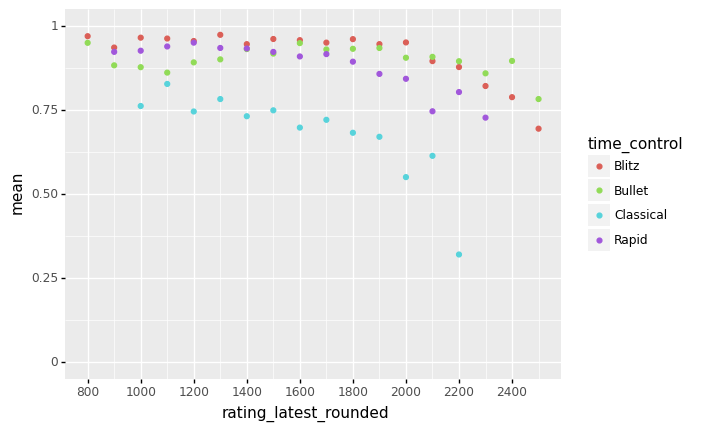

<ggplot: (8793304577765)>

In [201]:
y_bin_100_by_rating = df_100.groupby(["rating_latest_rounded","time_control"])['y_bin'].agg([np.mean,len])
(ggplot(y_bin_100_by_rating[y_bin_100_by_rating['len']>=25].reset_index(),
        aes(x='rating_latest_rounded',y='mean',color='time_control')) +
 geom_point() +
      scale_x_continuous(breaks=list(range(600,2600,200))) +
         ylim([0,1])
       )

In [202]:
y_cont_100_by_rating = df_100_reg.groupby(["rating_latest_rounded",'time_control'])['y_cont'].agg([np.mean,len]).reset_index()
y_cont_100_by_rating.head()

,rating_latest_rounded,time_control,mean,len
0,600,Blitz,23.500000,2.0
1,600,Bullet,18.000000,1.0
2,600,Rapid,242.000000,1.0
3,700,Blitz,59.333333,3.0
4,700,Bullet,669.000000,1.0


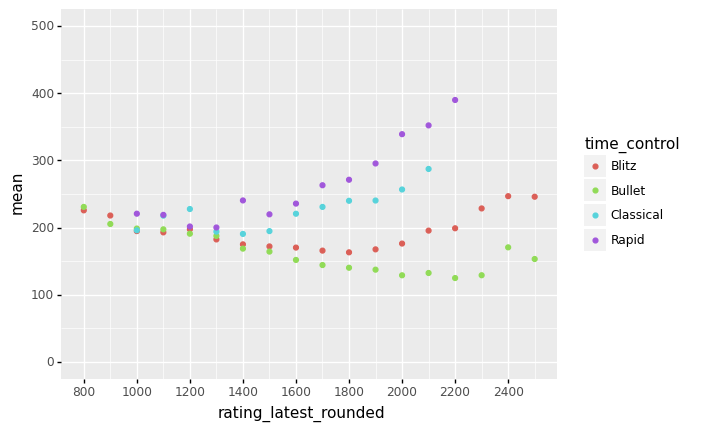

<ggplot: (8793295839073)>

In [203]:
(ggplot(y_cont_100_by_rating.query('len>=25'),aes(x='rating_latest_rounded',y='mean',color='time_control')) +
        geom_point() +
    ylim(0,500) +
     scale_x_continuous(breaks=list(range(600,2600,200)))
        
       )

# Modeling

In [204]:
predictors = ['rating_latest','blitz','bullet','rapid','rating_peak_diff','rating_30_diff']
df_100_predictors = sm.add_constant(df_100[predictors])
logit_100 = sm.Logit(endog=df_100['y_bin'],exog=df_100_predictors).fit()
logit_100.summary()

Optimization terminated successfully.
         Current function value: 0.303149
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  y_bin   No. Observations:                21641
Model:                          Logit   Df Residuals:                    21634
Method:                           MLE   Df Model:                            6
Date:                Tue, 03 Aug 2021   Pseudo R-squ.:                 0.08724
Time:                        20:20:26   Log-Likelihood:                -6560.5
converged:                       True   LL-Null:                       -7187.5
Covariance Type:            nonrobust   LLR p-value:                9.708e-268
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.7820      0.142     12.593      0.000       1.505       2.059
rating_latest       -0.0007   7.68e-05     -8.774      0.000      -0.001      -0.001
blitz                1.9571      0.065     29.933      0.000       1.829       2.085
bullet               1.4601      0.065     22.603      0.000       1.334       1.587
rapid                1.2828      0.066     19.295      0.000       1.152       1.413
rating_peak_diff    -0.0034      0.000     -8.190      0.000      -0.004      -0.003
rating_30_diff      -0.0006      0.000     -1.592      0.111      -0.001       0.000
====================================================================================
"""

In [205]:
# Regression
df_100_reg_predictors = sm.add_constant(df_100_reg[predictors])
ols_100 = sm.OLS(endog=df_100_reg['y_cont'],exog=df_100_reg_predictors).fit()
ols_100.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 y_cont   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     282.3
Date:                Tue, 03 Aug 2021   Prob (F-statistic):               0.00
Time:                        20:20:26   Log-Likelihood:            -1.2693e+05
No. Observations:               19407   AIC:                         2.539e+05
Df Residuals:                   19400   BIC:                         2.539e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              286.4500      7.765     36.888      0.000     271.229     301.671
rating_latest       -0.0219      0.004     -5.676      0.000      -0.029      -0.014
blitz              -36.3767      4.477     -8.125      0.000     -45.152     -27.602
bullet             -54.6906      4.648    -11.768      0.000     -63.800     -45.581
rapid               39.7287      4.865      8.166      0.000      30.193      49.265
rating_peak_diff     0.4194      0.017     24.563      0.000       0.386       0.453
rating_30_diff      -0.0497      0.019     -2.656      0.008      -0.086      -0.013
==============================================================================
Omnibus:                     3474.703   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5691.137
Skew:                           1.232   Prob(JB):                         0.00
Kurtosis:                       3.983   Cond. No.                     1.27e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# All-Xs model

In [231]:
df_base_all = pd.concat([df_base for x in range(10)])
def get_target_rating_gain(x):
    die = np.random.randint(1,4)
    if die == 1:
        return np.random.randint(1,100)
    elif die == 2:
        return np.random.randint(1,300)
    elif die == 3:
        if x < 1500:
            return np.random.randint(1,1000)
        elif x < 2000:
            return np.random.randint(1,800)
        else:
            return np.random.randint(1,600)
    else:
        print(1/0)

df_base_all['target_rating_gain'] = df_base_all['rating_latest'].apply(get_target_rating_gain)
df_base_all['target_rating'] = df_base_all['rating_latest'] + df_base_all['target_rating_gain']
print(df_base_all.shape)
df_base_all.head()

(216410, 19)


,user_id,time_control,date,rating_latest,rating_30,rating_90,rating_180,rating_peak,rating_30_diff,rating_90_diff,rating_180_diff,rating_peak_diff,rating_latest_rounded,blitz,bullet,classical,rapid,target_rating_gain,target_rating
0,4250,Blitz,2019-08-04,1615,1505.0,1525.0,1555.0,1636,110.0,90.0,60.0,-21,1600,1,0,0,0,266,1881
1,10683,Blitz,2019-08-04,1216,1109.0,1031.0,NaN,1216,107.0,185.0,NaN,0,1200,1,0,0,0,422,1638
2,10440,Blitz,2019-08-04,1433,1522.0,1414.0,1234.0,1598,-89.0,19.0,199.0,-165,1400,1,0,0,0,514,1947
3,10837,Bullet,2019-08-04,1604,1606.0,NaN,NaN,1761,-2.0,NaN,NaN,-157,1600,0,1,0,0,253,1857
4,15733,Blitz,2019-08-04,1156,1253.0,NaN,NaN,1253,-97.0,NaN,NaN,-97,1200,1,0,0,0,30,1186


In [234]:
df_base_all.groupby("rating_latest_rounded")['target_rating_gain'].describe().round()

,count,mean,std,min,25%,50%,75%,max
rating_latest_rounded,,,,,,,,
600,40.0,303.0,318.0,2.0,60.0,128.0,619.0,913.0
700,60.0,268.0,282.0,3.0,47.0,124.0,439.0,991.0
800,920.0,214.0,240.0,1.0,52.0,105.0,277.0,994.0
900,2150.0,230.0,259.0,1.0,52.0,104.0,282.0,999.0
1000,4870.0,233.0,261.0,1.0,51.0,115.0,287.0,999.0
1100,7690.0,234.0,259.0,1.0,53.0,117.0,289.0,999.0
1200,11740.0,231.0,258.0,1.0,52.0,112.0,286.0,999.0
1300,13380.0,231.0,258.0,1.0,52.0,116.0,287.0,999.0
1400,18280.0,237.0,261.0,1.0,53.0,119.0,292.0,999.0


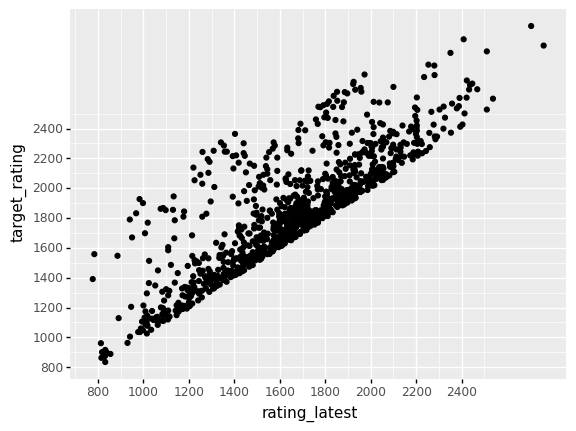

<ggplot: (8793292764275)>

In [235]:
(ggplot(df_base_all.sample(1000),aes(x='rating_latest',y='target_rating')) +
 geom_point() +
 scale_x_continuous(breaks=list(range(800,2500,200))) +
  scale_y_continuous(breaks=list(range(800,2500,200)))

        
       )

# Evaluation

In [144]:
df_100['prob'] = logit_100.predict(exog=df_100_predictors)
df_100['prob'].describe()

count    21641.000000
mean         0.896770
std          0.081816
min          0.486219
25%          0.886142
50%          0.921800
75%          0.944920
max          0.998790
Name: prob, dtype: float64

In [145]:
df_100_reg['pred'] = ols_100.predict(exog=df_100_reg_predictors)
df_100_reg['pred'].describe()

count    19407.000000
mean       192.633792
std         49.516644
min       -219.750272
25%        162.311230
50%        188.173332
75%        220.016395
max        306.193002
Name: pred, dtype: float64

In [146]:
df_100['prob'].mean()

0.8967700198696923

In [147]:
df_100['y_bin'].mean()

0.8967700198696917

## Features
- Target time control (likely interacted with various other features)
- Current rating (likely nonlinear relationship)
- Rating growth in last 30 days / 90 days / 180 days
- Rating volatility measures
- Peak historical rating relative to current rating
- Rating in other time controls + puzzles
- Rating growth in other time controls + puzzles
- Difference between other time control ratings + target time control rating
- How long you've been on lichess
- How many games you've played (ever, and within last 30 days, and within the target time control - if you haven't played many it could mean more uncertainty). Consider that most discord bot users will have played more recent rated games in the target time control than the typical user in the training data. 
- Last time you played a rated game in the target time control (if it's a long time ago, it could mean more uncertainty)

## Outcomes
- Will you ever achieve a rating that's X rating points higher than your current rating in the next Y months (X is calculated from target rating submitted by user, Y = 24?)
- If so, when will you first reach the target rating? (point estimate + prediction interval of dates) - use number of days as outcome, then transform to date for the bot message

## Notes:
- Might want to train multiple models for various values of X between 0 and 500 (with multiples of 10 to speed up, maybe, but smaller multiples for low values of X)
- Might want to exclude certain accounts (if they stop playing on lichess or in that time control recently, if they are very new, if something else is weird)
- Use cross-validation since sample size might be constrained
- Need to impute nulls
- Need to write code for scoring based on discord input (including lichess API querying)
- Need to figure out how to make prediction interval
- Add more comments + documentation to final version
